In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-03_12-45_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

YM       0.333333
NQ       0.333333
ES       0.333333
total    1.000000
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    22802.6
NQ    21690.4
YM    31639.8
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

76132.80000000002

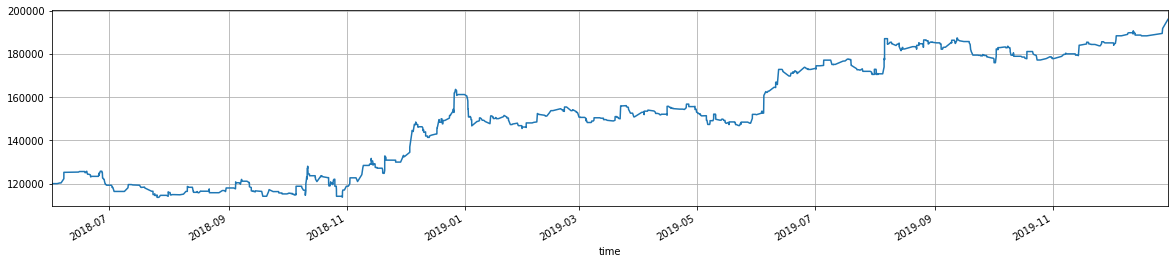

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    344
 NQ    276
 YM    612
 Name: action, dtype: int64, 1232)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.834951
 NQ    0.669903
 YM    1.485437
 Name: action, dtype: float64, 2.9902912621359223)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     722.4
NQ     579.6
YM    1285.2
Name: commission, dtype: float64

In [15]:
df.commission.sum()

2587.2000000000003

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
YM,0.41,103.40,808.50,-377.00,2.14,109.05,306.0
NQ,0.38,157.18,2675.13,-1365.30,1.96,170.06,138.0
ES,0.45,132.57,984.76,-558.15,1.76,136.16,172.0
total,0.41,123.59,1245.80,-658.55,1.89,122.23,616.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,NQ,YM,total
ES,1.000000,0.067887,0.395983,0.517582
NQ,0.067887,1.000000,0.137573,0.831834
YM,0.395983,0.137573,1.000000,0.572765
total,0.517582,0.831834,0.572765,1.000000


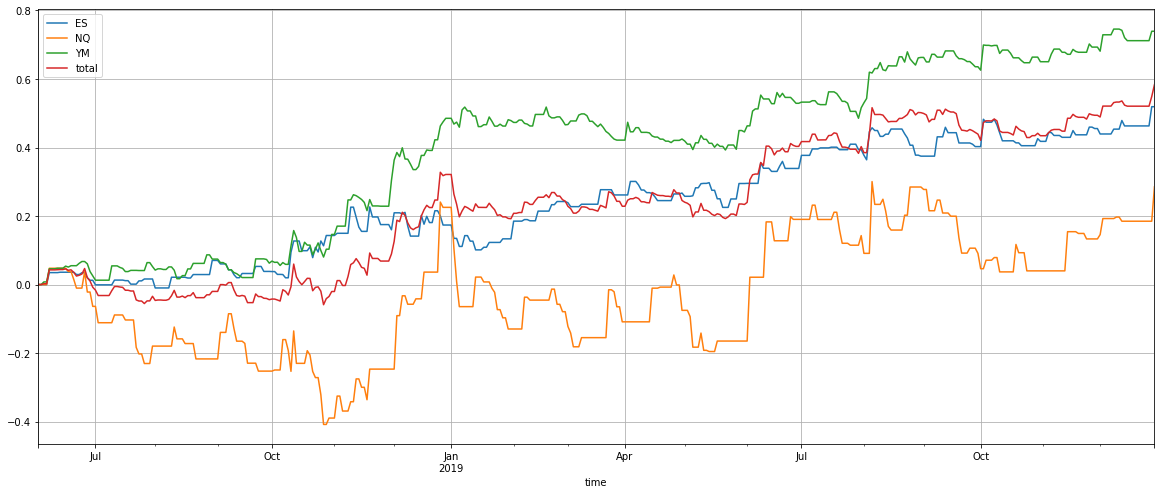

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

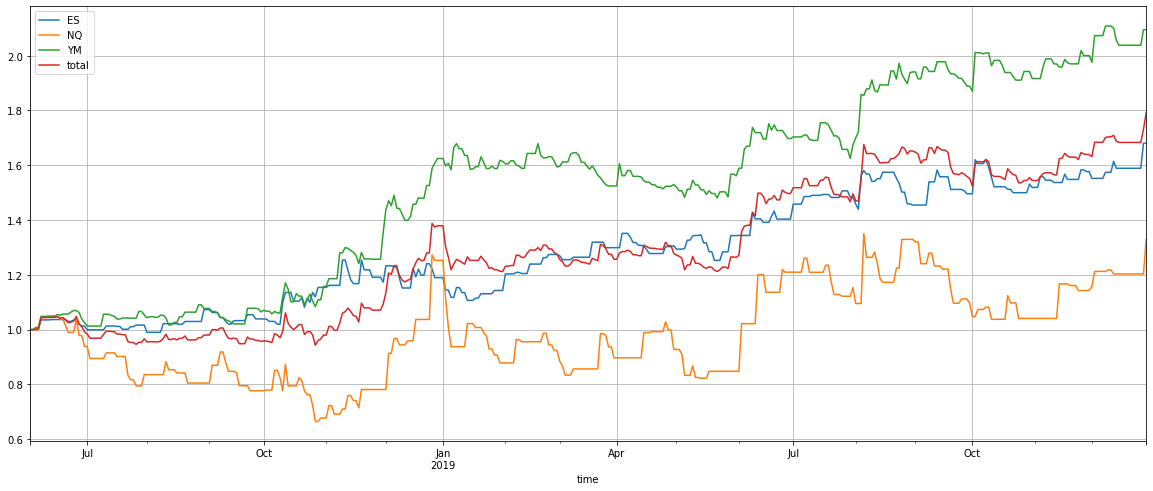

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,NQ,YM,total
Annual return,0.373772,0.190699,0.571905,0.428865
Cumulative returns,0.680658,0.330240,1.094794,0.792248
Annual volatility,0.251888,0.576582,0.252505,0.251175
Sharpe ratio,1.384269,0.575241,1.916048,1.544961
Calmar ratio,3.173385,0.520898,4.853752,3.381931
Stability,0.944708,0.456621,0.899791,0.905380
Max drawdown,-0.117783,-0.366096,-0.117827,-0.126811
Omega ratio,1.464539,1.186944,1.554798,1.406297
Sortino ratio,2.840509,1.101396,4.205861,2.972341
Skew,2.171188,2.501083,1.954259,1.605029


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,NQ,YM,total
time,,,,
2018-06-30,1.26,-6.17,2.55,-0.77
2018-07-31,0.38,-10.95,2.77,-2.61
2018-08-31,5.57,-3.67,2.21,1.43
2018-09-30,-3.16,-3.50,-1.18,-2.38
2018-10-31,11.06,-12.81,8.75,2.41
2018-11-30,1.68,15.36,17.04,11.58
2018-12-31,1.40,60.35,19.92,26.12
2019-01-31,-3.95,-29.89,-0.66,-12.12
2019-02-28,11.51,5.18,-1.23,5.25


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        68.0
NQ        33.0
YM       109.0
total     79.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-08-06 03:16:30,NQ,BUY,7353.50,9320.8
2018-12-26 15:30:30,NQ,BUY,5999.00,9075.8
2019-06-04 16:22:30,NQ,BUY,7069.00,8190.8
2019-06-12 08:40:30,NQ,SELL,7480.50,7010.8
2018-12-04 18:04:00,NQ,SELL,6977.00,6755.8
...,...,...,...,...
2019-01-04 16:01:00,NQ,BUY,6315.75,-2834.2
2018-10-26 18:35:30,NQ,BUY,6916.50,-3329.2
2018-10-12 02:13:30,NQ,BUY,7094.50,-3609.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,NQ,YM,total
time,,,,
2018-12-26,-0.014898,0.226895,0.041145,0.084381
2019-08-06,0.011770,0.233020,-0.002335,0.080818
2018-10-11,0.033435,0.125145,0.046435,0.068338
2019-06-04,0.000000,0.204770,0.000000,0.068257
2018-11-20,0.073958,0.093520,0.032895,0.066791
...,...,...,...,...
2018-10-22,-0.031148,-0.046980,-0.027835,-0.035321
2019-01-04,-0.023230,-0.070855,-0.014730,-0.036272
2018-10-12,0.000000,-0.090230,-0.020105,-0.036778
